# Fitting

In [54]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio, Spectrum, coat_spectrum, spectrum_to_angular, spectrum_to_radial
from analysis import hist_ensamble
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [55]:
def model_to_csr(model_list):
    csr_list = []
    for model in model_list:
        channel = model.channel
        spectrum = channel_spectrum(channel)

        csr = complex_spacing_ratio(spectrum)
        csr_list.append(csr)
        
    return csr_list
    

In [56]:
path = "../../numerical_experiments/diluted_traceout/data/"

## Radial and Angular Distribution

In [57]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=5.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L5_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L5_list = spectrum_to_angular(csr_integrable_list)

In [58]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=10.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L10_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L10_list = spectrum_to_angular(csr_integrable_list)

In [59]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=30_reorder.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L30_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L30_list = spectrum_to_angular(csr_integrable_list)

In [60]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=50_reorder.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L50_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L50_list = spectrum_to_angular(csr_integrable_list)

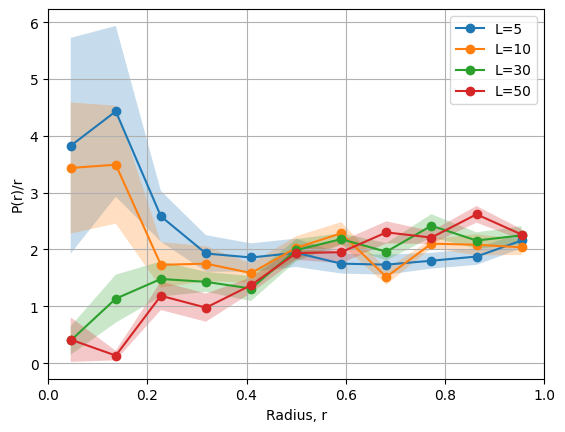

In [61]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_L5_list, bins=np.linspace(0, 1, 12))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.25)
plt.plot(center_bins, hist/center_bins, 'o-', label='L=5')

center_bins, hist, hist_err = hist_ensamble(radial_integrable_L10_list, bins=np.linspace(0, 1, 12))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.25)
plt.plot(center_bins, hist/center_bins, 'o-', label='L=10')

center_bins, hist, hist_err = hist_ensamble(radial_integrable_L30_list, bins=np.linspace(0, 1, 12))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.25)
plt.plot(center_bins, hist/center_bins, 'o-', label='L=30')

center_bins, hist, hist_err = hist_ensamble(radial_integrable_L50_list, bins=np.linspace(0, 1, 12))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.25)
plt.plot(center_bins, hist/center_bins, 'o-', label='L=50')

plt.xlim(0, 1)
plt.xlabel('Radius, r')
plt.ylabel('P(r)/r')
plt.legend()
plt.grid()
plt.savefig("figures/transition_radial.pdf")
plt.show()

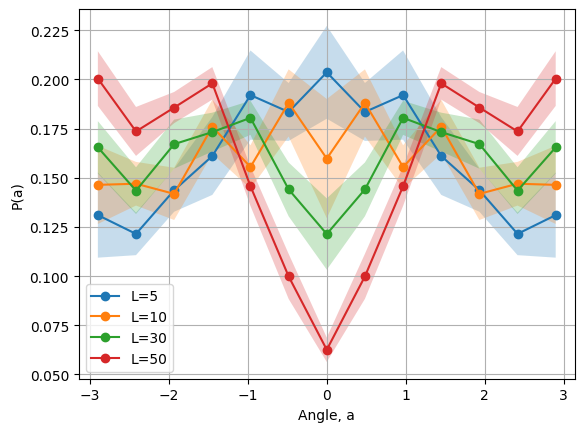

In [62]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_L5_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=5')

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L10_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=10')

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L30_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=30')

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L50_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=50')

plt.xlim(-np.pi, np.pi)
plt.xlabel('Angle, a')
plt.ylabel('P(a)')
plt.legend()
plt.grid()
plt.savefig("figures/transition_angular.pdf")
plt.show()


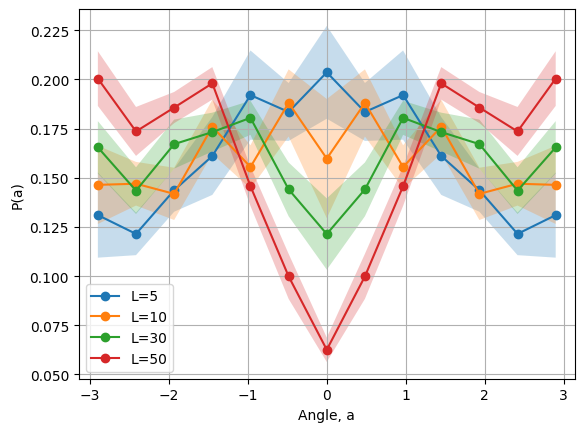

In [63]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_L5_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=5')

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L10_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=10')

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L30_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=30')

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L50_list, bins=np.linspace(-np.pi, np.pi, 14))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25)
plt.plot(center_bins, hist, 'o-', label='L=50')

plt.xlim(-np.pi, np.pi)
plt.xlabel('Angle, a')
plt.ylabel('P(a)')
plt.legend()
plt.grid()
plt.savefig("figures/transition_angular.pdf")
plt.show()


## Comparison with Theory

### Radial

In [76]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=5.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L5_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L5_list = spectrum_to_angular(csr_integrable_list)

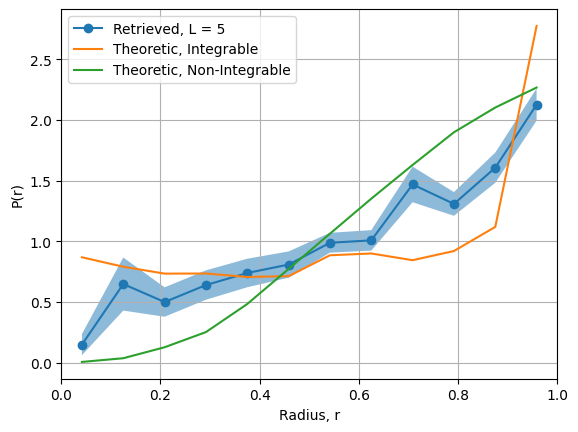

In [107]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_L5_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.5)
plt.plot(center_bins, hist, 'o-', label='Retrieved, L = 5')

center_bins, hist, hist_err = pkl.load(open(path + "radial_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "radial_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Non-Integrable')


plt.xlim(0, 1)
#plt.ylim(-0.5, 10)
plt.xlabel('Radius, r')
plt.ylabel('P(r)')
plt.legend()
plt.grid()
plt.savefig("figures/transition_radial_L=5.svg")

plt.show()

In [93]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=20_reorder.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L20_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L20_list = spectrum_to_angular(csr_integrable_list)

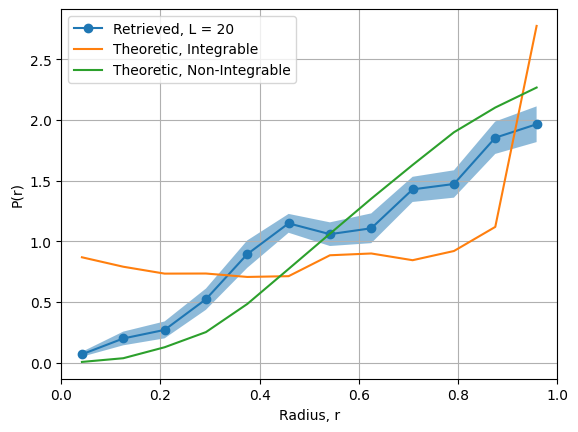

In [108]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_L20_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.5)
plt.plot(center_bins, hist, 'o-', label='Retrieved, L = 20')

center_bins, hist, hist_err = pkl.load(open(path + "radial_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "radial_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Non-Integrable')


plt.xlim(0, 1)
plt.xlabel('Radius, r')
plt.ylabel('P(r)')
plt.legend()
plt.grid()
plt.savefig("figures/transition_radial_L=20.svg")

plt.show()

In [89]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=30_reorder.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L30_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L30_list = spectrum_to_angular(csr_integrable_list)

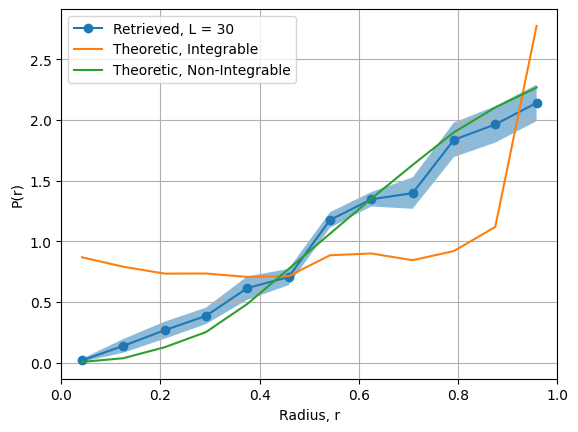

In [109]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_L30_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.5)
plt.plot(center_bins, hist, 'o-', label='Retrieved, L = 30')

center_bins, hist, hist_err = pkl.load(open(path + "radial_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "radial_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Non-Integrable')


plt.xlim(0, 1)
plt.xlabel('Radius, r')
plt.ylabel('P(r)')
plt.legend()
plt.grid()
plt.savefig("figures/transition_radial_L=30.svg")

plt.show()

In [86]:
model_integrable_list = pkl.load(open(f'models/integrable_model_4_L=50_reorder.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L50_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L50_list = spectrum_to_angular(csr_integrable_list)

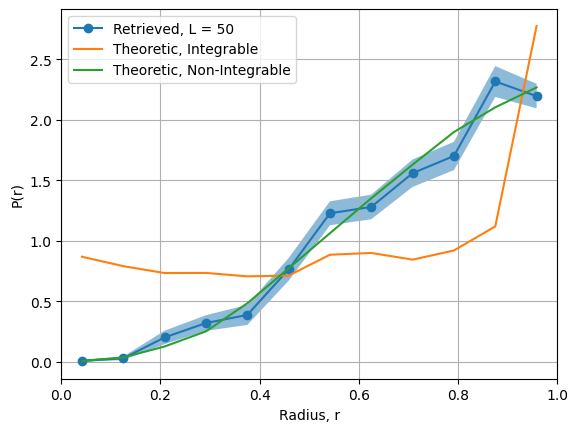

In [110]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_L50_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.5)
plt.plot(center_bins, hist, 'o-', label='Retrieved, L = 50')

center_bins, hist, hist_err = pkl.load(open(path + "radial_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "radial_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Non-Integrable')


plt.xlim(0, 1)
plt.xlabel('Radius, r')
plt.ylabel('P(r)')
plt.legend()
plt.grid()

plt.savefig("figures/transition_radial_L=50.svg")

plt.show()

### Angular

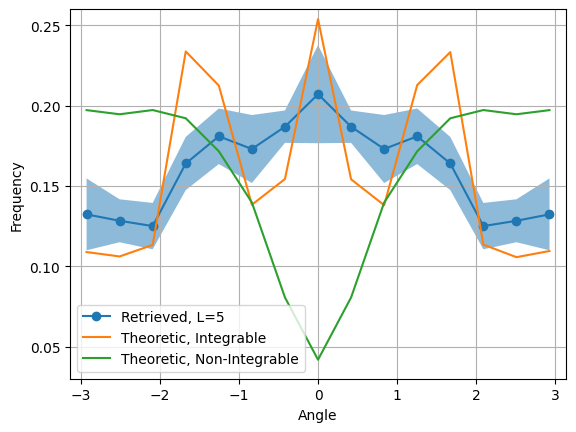

In [111]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_L5_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved, L=5')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)

center_bins, hist, hist_err = pkl.load(open(path + "angular_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "angular_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Theoretic, Non-Integrable')


plt.xlim(-np.pi, np.pi)
plt.ylim(0.03, 0.26)
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.savefig("figures/transition_angular_L=5.svg")

plt.show()

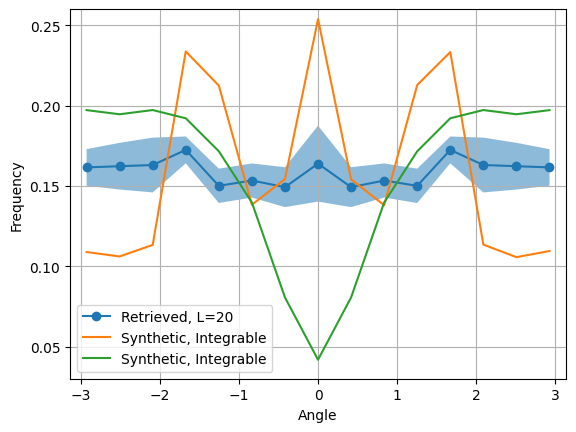

In [112]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_L20_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved, L=20')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)

center_bins, hist, hist_err = pkl.load(open(path + "angular_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "angular_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Integrable')


plt.xlim(-np.pi, np.pi)
plt.ylim(0.03, 0.26)
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.savefig("figures/transition_angular_L=20.svg")

plt.show()

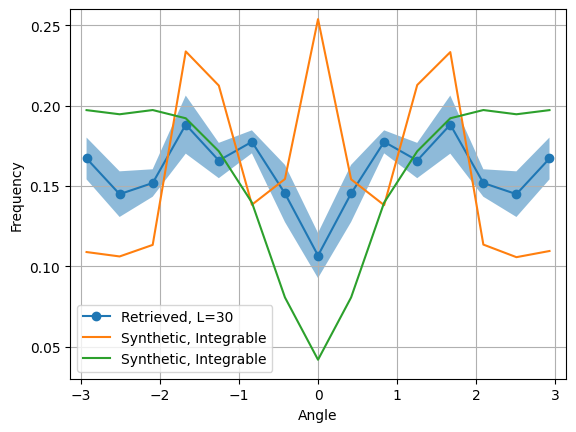

In [113]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_L30_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved, L=30')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)

center_bins, hist, hist_err = pkl.load(open(path + "angular_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "angular_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Integrable')


plt.xlim(-np.pi, np.pi)
plt.ylim(0.03, 0.26)
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.savefig("figures/transition_angular_L=30.svg")

plt.show()

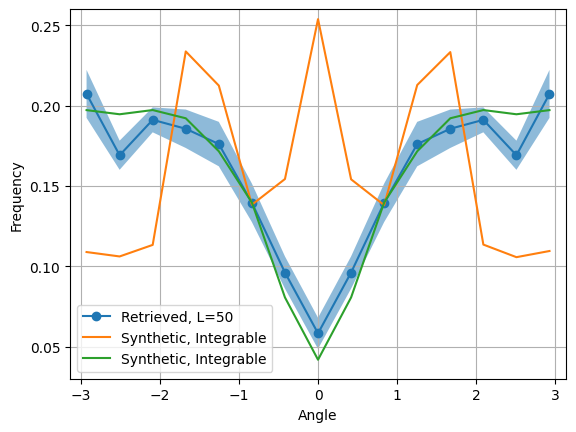

In [114]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_L50_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved, L=50')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)

center_bins, hist, hist_err = pkl.load(open(path + "angular_integrable_L=5.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "angular_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Integrable')


plt.xlim(-np.pi, np.pi)
plt.ylim(0.03, 0.26)
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.savefig("figures/transition_angular_L=50.svg")

plt.show()